# Задание 7

Теперь попробуем учесть в наших расчётах затраты с налогами и посчитаем валовую прибыль, то есть ту сумму, которую мы фактически получили в результате реализации товаров за рассматриваемый период.

Для каждого дня в таблицах orders и courier_actions рассчитайте следующие показатели:

1. Выручку, полученную в этот день.
2. Затраты, образовавшиеся в этот день.
3. Сумму НДС с продажи товаров в этот день.
4. Валовую прибыль в этот день (выручка за вычетом затрат и НДС).
5. Суммарную выручку на текущий день.
6. Суммарные затраты на текущий день.
7. Суммарный НДС на текущий день.
8. Суммарную валовую прибыль на текущий день.
9. Долю валовой прибыли в выручке за этот день (долю п.4 в п.1).
10. Долю суммарной валовой прибыли в суммарной выручке на текущий день (долю п.8 в п.5).
Колонки с показателями назовите соответственно revenue, costs, tax, gross_profit, total_revenue, total_costs, total_tax, total_gross_profit, gross_profit_ratio, total_gross_profit_ratio

Колонку с датами назовите date.

Долю валовой прибыли в выручке необходимо выразить в процентах, округлив значения до двух знаков после запятой.

Результат должен быть отсортирован по возрастанию даты.

Поля в результирующей таблице: date, revenue, costs, tax, gross_profit, total_revenue, total_costs, total_tax, total_gross_profit, gross_profit_ratio,total_gross_profit_ratio

Чтобы посчитать затраты, в этой задаче введём дополнительные условия.

В упрощённом виде затраты нашего сервиса будем считать как сумму постоянных и переменных издержек. К постоянным издержкам отнесём аренду складских помещений, а к переменным — стоимость сборки и доставки заказа. Таким образом, переменные затраты будут напрямую зависеть от числа заказов.

Из данных, которые нам предоставил финансовый отдел, известно, что в августе 2022 года постоянные затраты составляли 120 000 рублей в день. Однако уже в сентябре нашему сервису потребовались дополнительные помещения, и поэтому постоянные затраты возросли до 150 000 рублей в день.

Также известно, что в августе 2022 года сборка одного заказа обходилась нам в 140 рублей, при этом курьерам мы платили по 150 рублей за один доставленный заказ и ещё 400 рублей ежедневно в качестве бонуса, если курьер доставлял не менее 5 заказов в день. В сентябре продакт-менеджерам удалось снизить затраты на сборку заказа до 115 рублей, но при этом пришлось повысить бонусную выплату за доставку 5 и более заказов до 500 рублей, чтобы обеспечить более конкурентоспособные условия труда. При этом в сентябре выплата курьерам за один доставленный заказ осталась неизменной.

```sql
with revenue_table AS (
  SELECT
    date,
    sum(price) AS revenue
  FROM
    (
      SELECT
        unnest_query.date,
        unnest_query.product_id,
        products.price AS price
      FROM
        (
          SELECT
            order_id,
            creation_time :: date AS date,
            unnest(product_ids) AS product_id
          FROM
            orders
        ) AS unnest_query
        JOIN products using (product_id)
      WHERE
        unnest_query.order_id not in (
          SELECT
            order_id
          FROM
            user_actions
          WHERE
            action = 'cancel_order'
        )
    ) AS subq
  GROUP BY
    1
),
completed_orders_table AS (
  SELECT
    creation_time :: date AS date,
    count(distinct order_id) AS completed_orders
  FROM
    orders
  WHERE
    order_id not in (
      SELECT
        order_id
      FROM
        user_actions
      WHERE
        action = 'cancel_order'
    )
  GROUP BY
    1
),
delivered_orders_table AS (
  SELECT
    time :: date AS date,
    count(DISTINCT order_id) AS delivered_orders
  FROM
    courier_actions
  WHERE
    action = 'deliver_order'
  GROUP BY
    1
),
cool_couriers AS (
  SELECT
    date,
    count(courier_id) AS good_couriers
  FROM
    (
      SELECT
        time :: date AS date,
        courier_id,
        count(DISTINCT order_id) AS orders_per_day
      FROM
        courier_actions
      WHERE
        action = 'deliver_order'
      GROUP BY
        1,
        2
    ) AS subq
  WHERE
    orders_per_day >= 5
  GROUP BY
    1
),
VAT AS (
  SELECT
    creation_time :: date AS date,
    sum(tax) AS tax
  FROM
    (
      SELECT
        *
      FROM
        (
          SELECT
            order_id,
            creation_time,
            unnest(product_ids) AS product_id
          FROM
            orders
        ) AS subq1
        JOIN (
          SELECT
            product_id,
            cASe
              WHEN name in (
                'сахар',
                'сухарики',
                'сушки',
                'семечки',
                'масло льняное',
                'виноград',
                'масло оливковое',
                'арбуз',
                'батон',
                'йогурт',
                'сливки',
                'гречка',
                'овсянка',
                'макароны',
                'баранина',
                'апельсины',
                'бублики',
                'хлеб',
                'горох',
                'сметана',
                'рыба копченая',
                'мука',
                'шпроты',
                'сосиски',
                'свинина',
                'рис',
                'масло кунжутное',
                'сгущенка',
                'ананас',
                'говядина',
                'соль',
                'рыба вяленая',
                'масло подсолнечное',
                'яблоки',
                'груши',
                'лепешка',
                'молоко',
                'курица',
                'лаваш',
                'вафли',
                'мандарины'
              ) then round(price / 110 * 10, 2)
              ELSE round(price / 120 * 20, 2)
            END AS tax
          FROM
            products
          ORDER BY
            (price - price / 120 * 20) desc,
            product_id ASc
        ) AS subq2 using (product_id)
      WHERE
        order_id not in (
          SELECT
            order_id
          FROM
            user_actions
          WHERE
            action = 'cancel_order'
        )
    ) AS subq3
  GROUP BY
    1
),
main_subquery AS (
  SELECT
    date,
    revenue,
    CASE
      WHEN DATE_PART('month', date) = 8 then 120000 + 140 * completed_orders + 150 * delivered_orders + 400 * coalesce(good_couriers, 0)
      ELSE 150000 + 115 * completed_orders + 150 * delivered_orders + 500 * coalesce(good_couriers, 0)
    END AS costs,
    tax
  FROM
    revenue_table
    JOIN completed_orders_table using (date)
    JOIN delivered_orders_table using (date)
    LEFT JOIN cool_couriers using (date)
    JOIN VAT using (date)
)
SELECT
  date,
  revenue :: int,
  round(costs :: decimal, 1) AS costs,
  round(tax :: decimal, 2) AS tax,
  round(revenue - costs :: decimal - tax, 2) AS gross_profit,
  round(
    (
      sum(revenue) over(
        ORDER BY
          date
      )
    ) :: decimal,
    1
  ) AS total_revenue,
  round(
    (
      sum(costs) over(
        ORDER BY
          date
      )
    ) :: decimal,
    1
  ) AS total_costs,
  round(
    (
      sum(tax) over(
        ORDER BY
          date
      )
    ) :: decimal,
    2
  ) AS total_tax,
  round(
    (
      sum(revenue) over(
        ORDER BY
          date
      ) - sum(costs) over(
        ORDER BY
          date
      ) - (
        sum(tax) over(
          ORDER BY
            date
        )
      ) :: decimal
    ),
    2
  ) AS total_gross_profit,
  round(
    (revenue - costs - tax) / revenue :: decimal * 100,
    2
  ) AS gross_profit_ratio,
  round(
    (
      sum(revenue) over(
        ORDER BY
          date
      ) - sum(costs) over(
        ORDER BY
          date
      ) - sum(tax) over(
        ORDER BY
          date
      )
    ) / (
      sum(revenue) over(
        ORDER BY
          date
      )
    ) :: decimal * 100,
    2
  ) AS total_gross_profit_ratio
FROM
  main_subquery
ORDER BY
  date
```

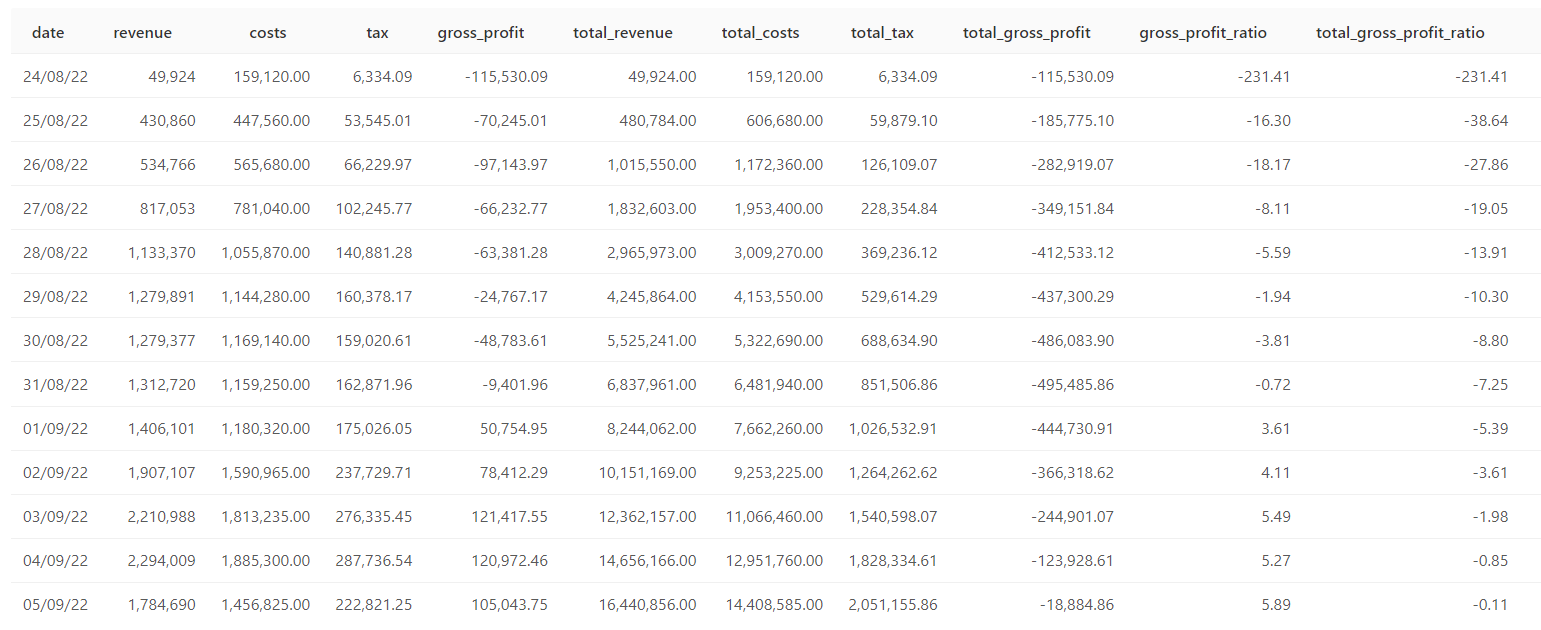

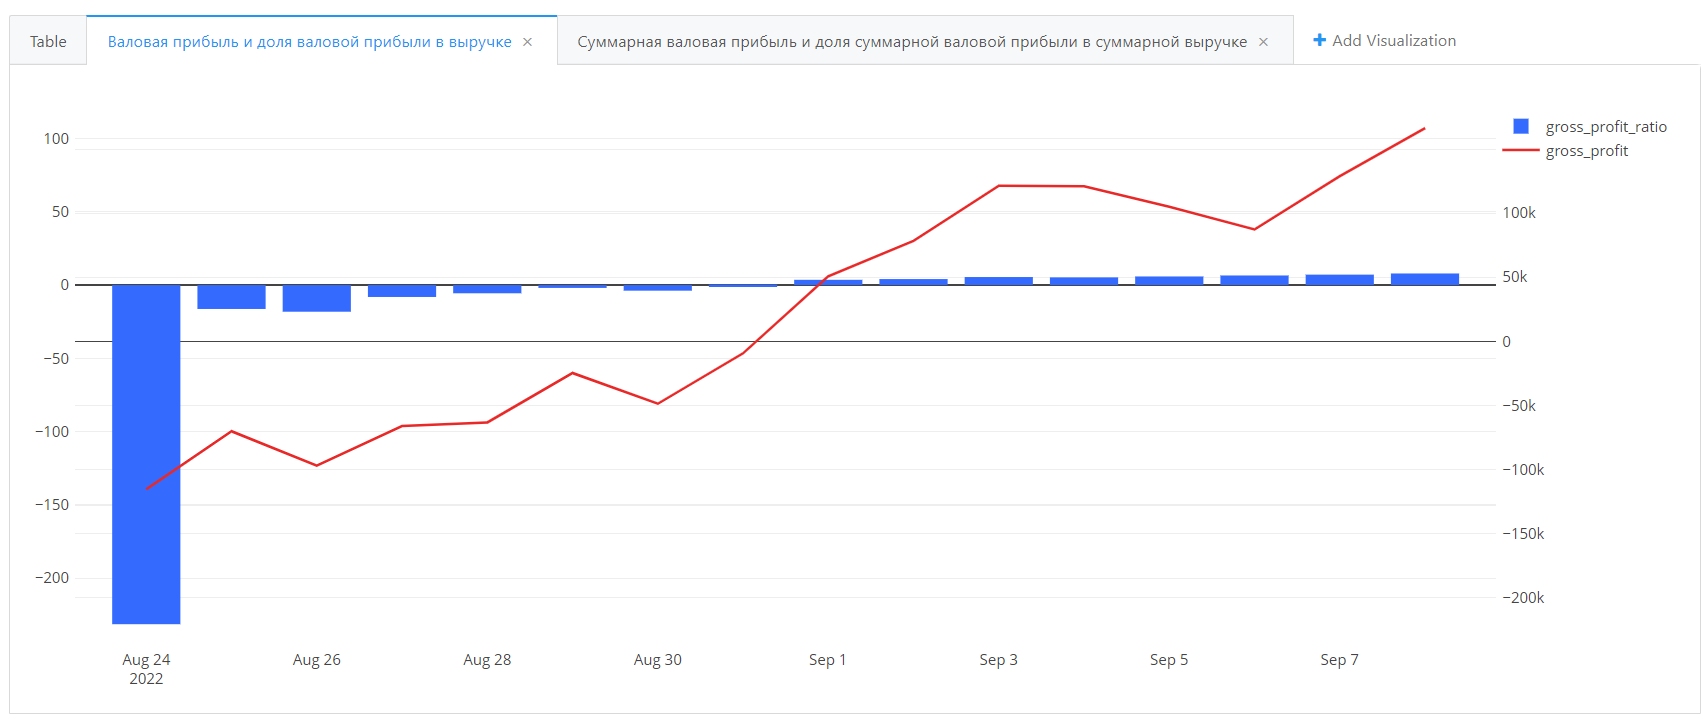

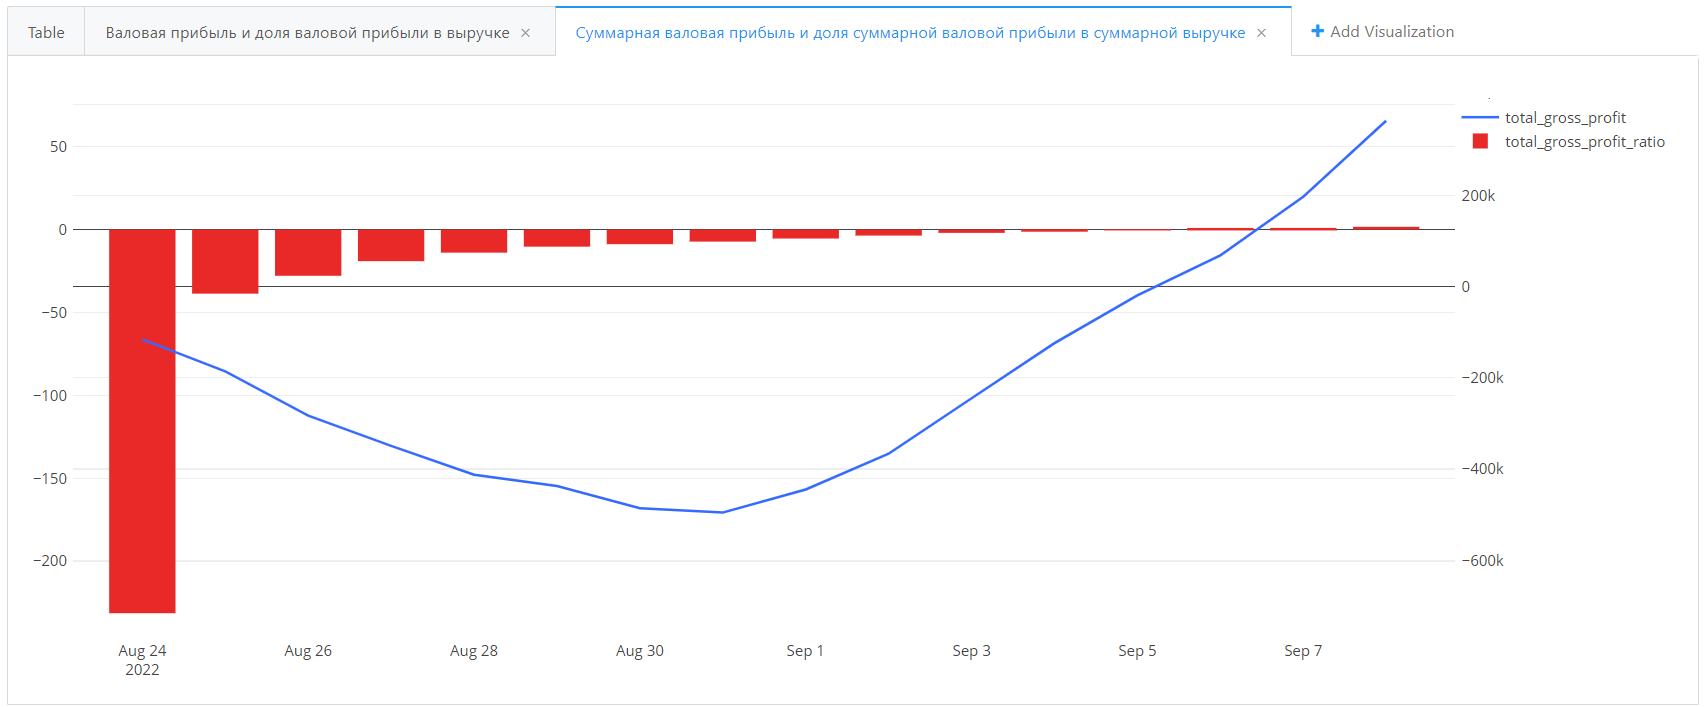